### IMPORTING LIBRARIES 

1. DATA HANDLING 

In [226]:
import pandas as pd
import numpy as np
import nltk

2. DATA PRE PROCESSING 

In [227]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

3. MODELS 

In [228]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Conv1D, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
import tensorflow as tf


4. TO SAVE MODELS

In [229]:
import joblib

### DATASET 

In [230]:
# Loading preprocessed dataset
file_path = "/Users/lalitaneeharikavajjhala/Desktop/Research credits /Data/norm_dataset.csv"
df = pd.read_csv(file_path)

In [231]:
# Previewing data head and extending the max column width
pd.set_option('display.max_colwidth', None)
df.head()

,text,norm
0,"Client agrees to pay to Company the sum of $5,000 (the “Contract Price”) to design and develop a website for Client (the “Client Website”) in accordance with the accompanying Scope of Work, attached to this Agreement as Exhibit A.",1
1,Company will use its best efforts to deliver the Client Website in the time frame specified in the Scope of Work.,1
2,"All written content submitted by Client for use in the Client Website must be typewritten, proofread and delivered to Company in the body of an email message or as a Microsoft Word electronic document or plaint text electronic document.",1
3,It is Client’s sole responsibility to check the accuracy of the written content and correct any errors prior to submission for final publication.,1
4,Client further agrees that Company may use and display the graphics and other web design elements of Client’s website as examples of Company website design and development work.,1


In [232]:
# Removeing duplicates
df.drop_duplicates(keep='first', inplace=True)

In [233]:
# Assigning norms to target variable. Values are already numeric
y = df['norm']
y

0      1
1      1
2      1
3      1
4      1
      ..
361    1
362    1
363    1
364    1
365    1
Name: norm, Length: 360, dtype: int64

### PRE PROCESSING

In [234]:
# Standard keras pre-processing
maxlen = 200 # Highest word count is 555 and mean is 43
max_words = 2000
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df.text)

# Functions to transform text to feature_vectors 
def get_features(text_series):
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=maxlen)

In [235]:
# Calling function to create features 'X'
X = get_features(df.text)

print(X.shape, y.shape)

(360, 200) (360,)


In [236]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0, shuffle=True, stratify=y)

In [237]:
# Law2vec 100 dimensional word embeddings 
from numpy import array, asarray, zeros
vocab_size = len(tokenizer.word_index) + 1

embeddings_dictionary = dict()
# This file contains pre trained word embeddings 
law2vec_file = open("/Users/lalitaneeharikavajjhala/Desktop/Research credits /Data/Law2Vec.100d.txt", encoding="utf8")

In [238]:
# Parsing each line and store word-vector pairs in a dictionary
for line in law2vec_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
law2vec_file.close()
# Here we are extracting a word and its corresponding embedding vector and storing in a dict

In [239]:
# Each row corresponds to a word with its 100 dimensional word vector
embedding_matrix = zeros((vocab_size, 100))


In [240]:
# tokenizer.word_index is a list of (word, id) tuples
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
# Initially this matrix is filled with zeros and later it will get filled with actual word vectors obtained from the pre trained embeddings 

### MODEL - CONVULUTION NEURAL NETWORK 

In [241]:
filter_length = 300
num_classes = 1 # since the number of output classes is 1 (PREDICTION = non or non norm)

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model = Sequential()
model.add(embedding_layer)
# model.add(Embedding(max_words, 20, input_length=maxlen))
model.add(Dropout(0.1))
model.add(Conv1D(filter_length, kernel_size=8, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 100)          230300    
                                                                 
 dropout_10 (Dropout)        (None, 200, 100)          0         
                                                                 
 conv1d_10 (Conv1D)          (None, 193, 300)          240300    
                                                                 
 global_max_pooling1d_10 (G  (None, 300)               0         
 lobalMaxPooling1D)                                              
                                                                 
 flatten_10 (Flatten)        (None, 300)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 301       
                                                     

In [242]:
# Fitting the model
callbacks = [
    ReduceLROnPlateau(), 
    EarlyStopping(patience=4), 
]

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    callbacks=callbacks)

Epoch 1/20


9/9 [==============================] - 0s 22ms/step - loss: 0.7624 - accuracy: 0.5278 - lr: 0.0010
Epoch 2/20
9/9 [==============================] - 0s 21ms/step - loss: 0.5236 - accuracy: 0.7431 - lr: 0.0010
Epoch 3/20
9/9 [==============================] - 0s 21ms/step - loss: 0.4089 - accuracy: 0.8924 - lr: 0.0010
Epoch 4/20
9/9 [==============================] - 0s 21ms/step - loss: 0.3292 - accuracy: 0.9410 - lr: 0.0010
Epoch 5/20
9/9 [==============================] - 0s 21ms/step - loss: 0.2689 - accuracy: 0.9549 - lr: 0.0010
Epoch 6/20
9/9 [==============================] - 0s 21ms/step - loss: 0.2232 - accuracy: 0.9688 - lr: 0.0010
Epoch 7/20
9/9 [==============================] - 0s 21ms/step - loss: 0.1810 - accuracy: 0.9861 - lr: 0.0010
Epoch 8/20
9/9 [==============================] - 0s 22ms/step - loss: 0.1453 - accuracy: 0.9965 - lr: 0.0010
Epoch 9/20
9/9 [==============================] - 0s 22ms/step - loss: 0.1193 - accuracy: 1.0000 - lr: 0.0010
Epoch 10/20
9/9 [====

### MODEL EVALUATION

In [243]:
# Evaluating using metrics
metrics = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))


3/3 [==============================] - 0s 6ms/step
loss: 0.29978039860725403
accuracy: 0.875


In [244]:
y_pred = model.predict(X_test)
thresholded_preds = (y_pred > 0.5).astype(int)  # Applying threshold for binary classification
precision = precision_score(y_test, thresholded_preds)
recall = recall_score(y_test, thresholded_preds)
f1 = f1_score(y_test, thresholded_preds)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


3/3 [==============================] - 0s 6ms/step
Precision: 0.8611111111111112
Recall: 0.8857142857142857
F1 Score: 0.8732394366197183


### PREDICTING

In [245]:
# Prediction
x = ["Each Party shall return to the other all of the other’s Confidential Information and any other material, information or samples relating to the Product which have been provided or made available to the other and shall not retain any copies and the Parties further agree not to make any further use of each other’s Confidential Information or any other information, data or samples relating to the Product provided or made available by the other Party, except as necessary to comply with its statutory, regulatory or licensing obligations; provided, however, that Kitov may retain such material, information and/or samples relating to the Product as may be necessary for Kitov to continue to sell the Product as permitted by Section ​5.4.4 below, following which, Kitov shall refrain from making any further use of Dexcel’s Confidential Information or any other information, data or samples and shall return any remaining Confidential Information and material, information or samples relating to the Product."]
xt = get_features(x)
prediction = model.predict(xt)
probas = (prediction > 0.5).astype(int)

if probas == [1]:
    tag = 'Norm'
else:
    tag = 'Non-norm'

print(prediction)
print(probas)
print(tag)

1/1 [==============================] - 0s 8ms/step
[[0.9178294]]
[[1]]
Norm


### SAVING THE MODELS

In [246]:
# Saving the tokenizer
joblib.dump(tokenizer, "/Users/lalitaneeharikavajjhala/Desktop/Research credits /Models/BinaryLabelTokenizer.pkl")

['/Users/lalitaneeharikavajjhala/Desktop/Research credits /Models/BinaryLabelTokenizer.pkl']

In [247]:
# Saving the model 
joblib.dump(model, "/Users/lalitaneeharikavajjhala/Desktop/Research credits /Models/BinaryLabelModel_CNN.pkl")

['/Users/lalitaneeharikavajjhala/Desktop/Research credits /Models/BinaryLabelModel_CNN.pkl']

/var/folders/lm/8dmqs1pd6qg4vn2y7m90m3pw0000gn/T/ipykernel_6670/369740287.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss_values, 'bo--', label='Training Loss', color='teal')
/var/folders/lm/8dmqs1pd6qg4vn2y7m90m3pw0000gn/T/ipykernel_6670/369740287.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, accuracy_values, 'ro--', label='Training Accuracy', color='orange')


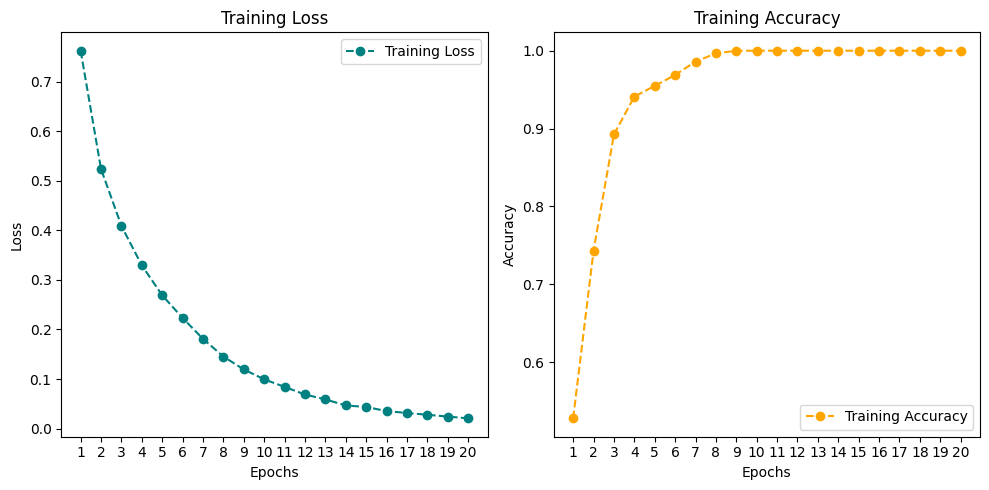

In [3]:
import matplotlib.pyplot as plt

# Define the epoch range
epochs = range(1, 21)  # Assuming 20 epochs

# Define the accuracy and loss values
loss_values = [0.7624, 0.5236, 0.4089, 0.3292, 0.2689, 0.2232, 0.1810, 0.1453, 0.1193, 0.0994,
               0.0842, 0.0688, 0.0589, 0.0467, 0.0436, 0.0354, 0.0315, 0.0279, 0.0242, 0.0207]
accuracy_values = [0.5278, 0.7431, 0.8924, 0.9410, 0.9549, 0.9688, 0.9861, 0.9965, 1.0000, 1.0000,
                   1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]

# Create a plot
plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo--', label='Training Loss', color='teal')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set ticks for whole number epochs
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, 'ro--', label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Set ticks for whole number epochs
plt.legend()

plt.tight_layout()
plt.show()
